C:\Users\vikas\AppData\Local\Temp\ipykernel_20764\2461015932.py:4: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d, gaussian_filter
C:\Users\vikas\AppData\Local\Temp\ipykernel_20764\2461015932.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d, gaussian_filter


Loading datasets...
Shape of x_train: (5124, 3197, 2)
Shape of x_test: (575, 3197, 2)
Class Weights: [0.01465347 1.        ]
Epoch 1/50
160/160 - 7s - loss: 0.7152 - accuracy: 0.5455 - val_loss: 0.6122 - val_accuracy: 0.7270 - 7s/epoch - 41ms/step
Epoch 2/50
160/160 - 4s - loss: 0.6940 - accuracy: 0.5691 - val_loss: 0.5901 - val_accuracy: 0.7530 - 4s/epoch - 25ms/step
Epoch 3/50
160/160 - 4s - loss: 0.6718 - accuracy: 0.5865 - val_loss: 0.5915 - val_accuracy: 0.7357 - 4s/epoch - 25ms/step
Epoch 4/50
160/160 - 4s - loss: 0.6393 - accuracy: 0.6305 - val_loss: 0.5718 - val_accuracy: 0.7461 - 4s/epoch - 25ms/step
Epoch 5/50
160/160 - 4s - loss: 0.6285 - accuracy: 0.6520 - val_loss: 0.5348 - val_accuracy: 0.7687 - 4s/epoch - 24ms/step
Epoch 6/50
160/160 - 4s - loss: 0.6137 - accuracy: 0.6584 - val_loss: 0.5227 - val_accuracy: 0.7600 - 4s/epoch - 25ms/step
Epoch 7/50
160/160 - 4s - loss: 0.5961 - accuracy: 0.6834 - val_loss: 0.5143 - val_accuracy: 0.7513 - 4s/epoch - 26ms/step
Epoch 8/50
160

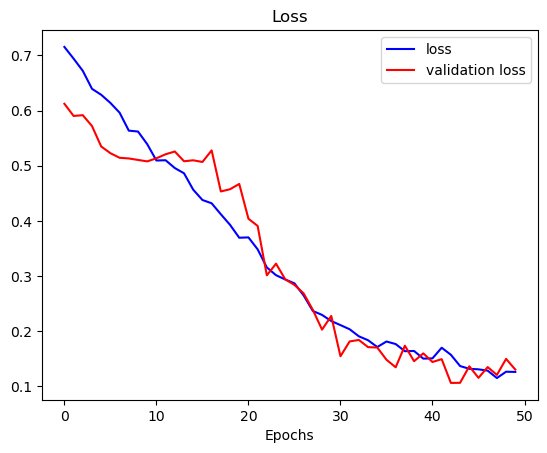

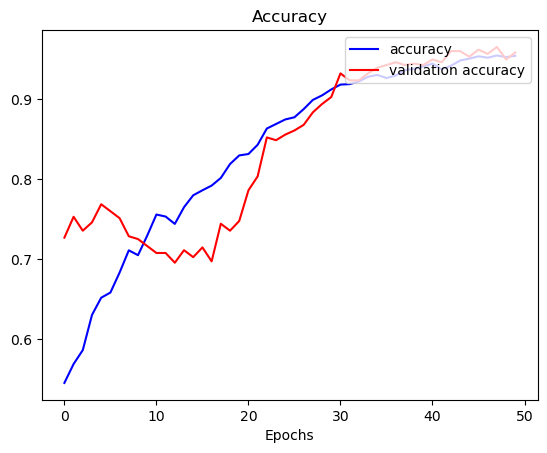

161/161 [==============================] - 2s 8ms/step
Validation for training data:
col_0     0    1
row_0           
0      4826  224
1         1   73


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d, gaussian_filter
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve, \
                            average_precision_score, auc
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from inspect import signature
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def main():
    print("Loading datasets...")
    train = pd.read_csv("Data/exoTrain.csv", encoding="ISO-8859-1")  # in dataframe format
    test = pd.read_csv("Data/exoTest.csv", encoding="ISO-8859-1")  # in dataframe format
    x_train = train.drop('LABEL', axis=1)
    x_test = test.drop('LABEL', axis=1)
    y_train = train.LABEL
    y_test = test.LABEL
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape((-1,1))-1
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape((-1,1))-1

    x_train = np.append(x_train, np.flip(x_train[0:37,:], axis=-1), axis=0)
    y_train = np.append(y_train, y_train[0:37]).reshape((-1,1))
    x_test = np.append(x_test, np.flip(x_test[0:5,:], axis=-1), axis=0)
    y_test = np.append(y_test, y_test[0:5]).reshape((-1,1))

    def detrender_normalizer(light_flux):
      flux1 = light_flux
      flux2 = gaussian_filter(flux1, sigma=10)
      flux3 = flux1 - flux2
      flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
      return flux3normalized

    x_train_p = detrender_normalizer(x_train)
    x_test_p = detrender_normalizer(x_test)

    x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / np.std(x_train, axis=1).reshape(-1,1))
    x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / np.std(x_test, axis=1).reshape(-1,1))

    x_train = np.stack([x_train, x_train_p], axis=2)
    x_test = np.stack([x_test, x_test_p], axis=2)

    print("Shape of x_train:", x_train.shape)
    print("Shape of x_test:", x_test.shape)

    model = Sequential()
    model.add(Conv1D(filters=8, kernel_size=11, activation='linear', input_shape=x_train.shape[1:]))
    model.add(MaxPool1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=16, kernel_size=11, activation='relu'))
    model.add(MaxPool1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=11, activation='relu'))
    model.add(MaxPool1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
    model.add(MaxPool1D(strides=4))
    model.add(Flatten())
    model.add(Dropout(0.5)) #prevents overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25)) #prevents overfitting
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    def shuffle_in_unison(a, b):
      rng_state = np.random.get_state()
      np.random.shuffle(a)
      np.random.set_state(rng_state)
      np.random.shuffle(b)

    def batch_generator(x_train, y_train, batch_size=32):
        half_batch = batch_size // 2
        x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32') #empty matrix for input
        y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32') #empty matrix for output

        while True:
            pos_idx = np.where(y_train[:,0] == 1)[0]
            neg_idx = np.where(y_train[:,0] == 0)[0]

            np.random.shuffle(pos_idx)
            np.random.shuffle(neg_idx)

            x_batch[:half_batch] = x_train[pos_idx[:half_batch]]
            x_batch[half_batch:] = x_train[neg_idx[half_batch:batch_size]]
            y_batch[:half_batch] = y_train[pos_idx[:half_batch]]
            y_batch[half_batch:] = y_train[neg_idx[half_batch:batch_size]]

            shuffle_in_unison(x_batch,y_batch)

            for i in range(batch_size):
                sz = np.random.randint(x_batch.shape[1])
                x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
            yield x_batch, y_batch

    class_counts = np.bincount(y_train.flatten())
    total_samples = len(y_train)

    class_frequencies = class_counts / total_samples
    class_weights = 1 / class_frequencies

    class_weights /= max(class_weights)

    print("Class Weights:", class_weights)

    model.compile(optimizer=Adam(1e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
    hist = model.fit_generator(batch_generator(x_train, y_train, 32), \
                                validation_data=(x_test, y_test), \
                                verbose=0, epochs=5, \
                                steps_per_epoch=x_train.shape[0]//32)

    model.compile(optimizer=Adam(4e-5), loss = 'binary_crossentropy', metrics=['accuracy'])
    hist = model.fit_generator(batch_generator(x_train, y_train, 32),
                                validation_data=(x_test, y_test),
                                verbose=2, epochs=50,
                                steps_per_epoch=x_train.shape[0]//32)

    model_json = model.to_json()
    with open("model.json", "w") as  json_file:
      json_file.write(model_json)
    model.save_weights("model.h5")
    print("Saved model to disk")

    plt.plot(hist.history['loss'], color='b',label='loss')
    plt.plot(hist.history['val_loss'], color='r',label='validation loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()
    plt.plot(hist.history['accuracy'], color='b',label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='r',label='validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show()

    shuffle_in_unison(x_train,y_train)
    y_pred = model.predict(x_train)[:,0]
    pred = np.empty((1,len(y_pred)), dtype=object)
    pred = np.where(y_pred>=0.5, 1, 0)
    y_train = np.reshape(y_train,len(y_train))
    pred = np.reshape(pred,len(pred))

    print('Validation for training data:')
    conf_matrix = pd.crosstab(y_train, pred)
    print(conf_matrix)
main()

Loaded model from disk
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3187, 8)           184       
                                                                 
 max_pooling1d (MaxPooling1  (None, 797, 8)            0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 797, 8)            32        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 787, 16)           1424      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 197, 16)           0         
 g1D)                                                            
                                 

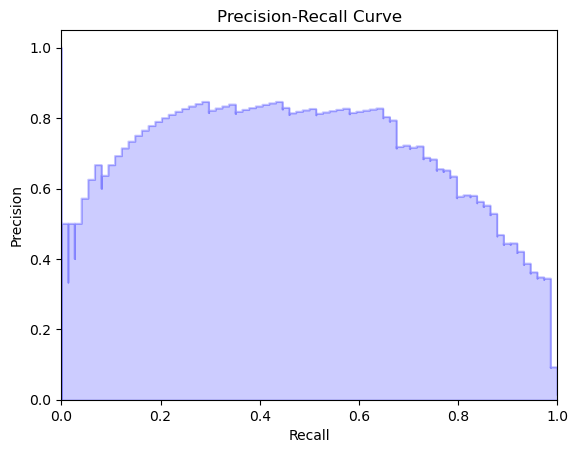

18/18 [==============================] - 0s 9ms/step
Validation for test data:
col_0    0   1
row_0         
0      541  24
1        0  10
Accuracy: 0.958 Precision: 0.294 Recall: 1.000 F_beta: 0.455
Area under precision-recall-curve: 0.559


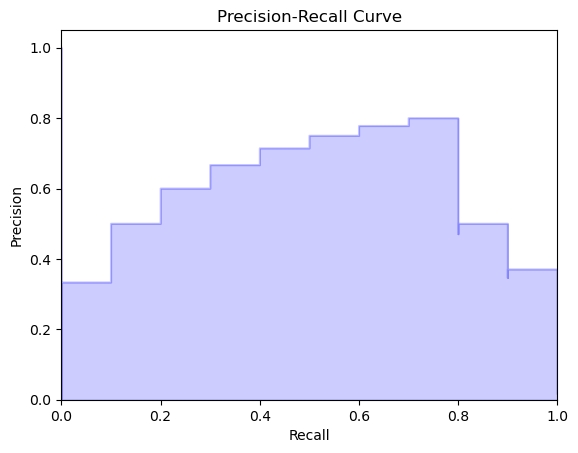

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d, gaussian_filter
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            confusion_matrix, fbeta_score, precision_recall_curve, \
                            average_precision_score, auc
from keras import backend as K
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, concatenate, Activation
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')
from inspect import signature
# from google.colab import drive
# drive.mount('/content/gdrive')
import h5py

# Just disables a warning, doesn't enable AVX/FMA
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Define main function
def main():
    # Upload and create model
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json) #load structure into new model
    loaded_model.load_weights("model.h5") #load weights into new model
    print("Loaded model from disk")
    loaded_model.summary()

    # Converting the formate from dataframe to numpy arrays (matrices)
    # and defining x-values and y-values for both the test and training set
    print("Loading datasets...")
    train = pd.read_csv("Data/exoTrain.csv", encoding= "ISO-8859-1") #on data frame format
    test = pd.read_csv("Data/exoTest.csv", encoding= "ISO-8859-1") #on data frame format
    x_train = train.drop('LABEL', axis=1)
    x_test = test.drop('LABEL', axis=1)
    y_train = train.LABEL
    y_test = test.LABEL
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape((-1,1))-1
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape((-1,1))-1

    # Add extra positive examples of light curves by flipping them
    x_train = np.append(x_train, np.flip(x_train[0:37,:], axis=-1), axis=0)
    y_train = np.append(y_train, y_train[0:37]).reshape((-1,1))
    x_test = np.append(x_test, np.flip(x_test[0:5,:], axis=-1), axis=0)
    y_test = np.append(y_test, y_test[0:5]).reshape((-1,1))

    # Define detrender function
    def detrender_normalizer(light_flux):
      flux1 = light_flux
      flux2 = gaussian_filter(flux1, sigma=10)
      flux3 = flux1 - flux2
      flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
      return flux3normalized

    # Detrend the data sets
    x_train_p = detrender_normalizer(x_train)
    x_test_p = detrender_normalizer(x_test)

    # Scale each observation to zero mean and unit variance
    x_train = ((x_train - np.mean(x_train, axis=1).reshape(-1,1)) / np.std(x_train, axis=1).reshape(-1,1))
    x_test = ((x_test - np.mean(x_test, axis=1).reshape(-1,1)) / np.std(x_test, axis=1).reshape(-1,1))

    # Stack the zero mean unit variance normalized data and the detrended data
    x_train = np.stack([x_train, x_train_p], axis=2)
    x_test = np.stack([x_test, x_test_p], axis=2)

    #Define a function for shuffeling in unison
    def shuffle_in_unison(a, b):
      rng_state = np.random.get_state()
      np.random.shuffle(a)
      np.random.set_state(rng_state)
      np.random.shuffle(b)

    #Make predictions for training data
    shuffle_in_unison(x_train,y_train)
    y_pred = loaded_model.predict(x_train)[:,0]
    pred = np.empty((1,len(y_pred)), dtype=object)
    pred = np.where(y_pred>=0.5, 1, 0)
    y_train = np.reshape(y_train,len(y_train))
    pred = np.reshape(pred,len(pred))

    # Create confusion matrix for training data
    print('Validation for training data:')
    conf_matrix = pd.crosstab(y_train, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_train, pred)
    precision = precision_score(y_train, pred)
    recall = recall_score(y_train, pred)
    fbeta = fbeta_score(y_train, pred, beta=1.0)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' \
          % (accuracy, precision, recall, fbeta))

    # Create a precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred, pos_label=1)
    auc_pr = auc(recall, precision)
    print('Area under precision-recall-curve: %.3f' % (auc_pr))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    # Make predictions for test data
    shuffle_in_unison(x_test,y_test)
    y_pred = loaded_model.predict(x_test)[:,0]
    pred = np.empty((1,len(y_pred)), dtype=object)
    pred = np.where(y_pred>=0.5, 1, 0)
    y_test = np.reshape(y_test,len(y_test))
    pred = np.reshape(pred,len(pred))

    # Create confusion matrix for test data
    print('Validation for test data:')
    conf_matrix = pd.crosstab(y_test, pred)
    print(conf_matrix)

    # Calculate precision and recall
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    fbeta = fbeta_score(y_test, pred, beta=1.0)
    print('Accuracy: %.3f Precision: %.3f Recall: %.3f F_beta: %.3f' \
          % (accuracy, precision, recall, fbeta))

    # Create a precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred, pos_label=1)
    auc_pr = auc(recall, precision)
    print('Area under precision-recall-curve: %.3f' % (auc_pr))
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.show()

    '''
    b = np.reshape(y_pred, (570,1))
    N = np.sum(y_test == 0)
    P = np.sum(y_test == 1)
    false_positive_rate = []
    true_positive_rate = []

    # Calculating and plotting ROC-curve
    threshold  = np.linspace(0.01, 0.99, 99)
    for i in range(len(threshold)):
        prediction = np.empty(len(x_test), dtype = int)
        prediction = np.where(b[:, 0] > threshold[i], \
                             0, 1)
        FP = np.sum((prediction == 1)&(y_test == 0))
        TP = np.sum((prediction == 1)&(y_test == 1))

        false_positive_rate.append(FP/N)
        true_positive_rate.append(TP/P)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.show()
    '''


main()